# CNN Cancer Detection

## Introduction

In this notebook I will employ two different CNN architectures to perform metastatic cancer detection in small image patches taken from larger digital pathology scans. It is a binary classification. The dataset is separated into a training set and a test set. The image labels are provided for the trainig set and the test set is used for competition scoring. The images have dimensions `(196,196,3)` and there are 220025 training images and  57458 test images.


## EDA

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

The image data is stored in folders and the labels are stored as a csv file. The images and labels will need to be combined for training a NN model. The files are in the format `img_dir/img_id + .tif` so I will create a new column in the csv that contains the image paths for each image. This will help when reading in the data later on.

In [3]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
labels_dir = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

labels_df = pd.read_csv(labels_dir)
labels_df['filename'] = labels_df.apply(lambda x: os.path.join(train_dir, x['id']+'.tif'), axis=1)
labels_df["label"] = labels_df["label"].astype(str)

labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


### Sample Data

I will start by looking at sample images from the cancerous cases and non-cancerous cases.

No Cancer


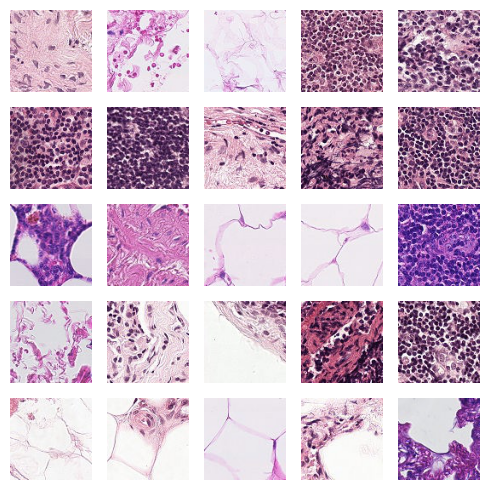

Cancer


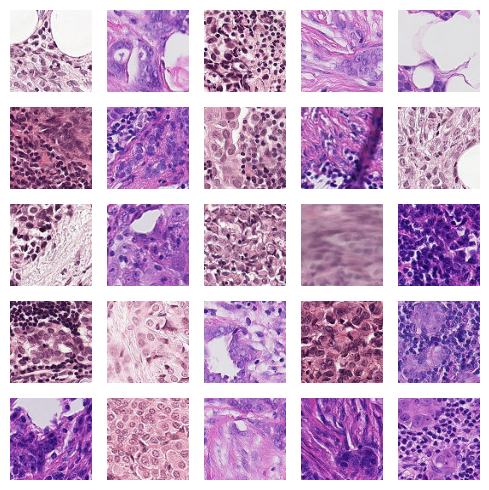

In [4]:
import random
def sample_and_plot(n_samples, df):
    n_rows,n_cols = int(n_samples**0.5), int(n_samples**0.5)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5,5))
    sampled_df = df.sample(n_rows**2)
    
    for i, ax in enumerate(axes.flat):
        idx,label,filename = sampled_df.values[i]
        im = Image.open(filename)
        ax.imshow(im)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()
print('No Cancer')
sample_and_plot(25, labels_df[labels_df['label']=='0'])

print('Cancer')
sample_and_plot(25, labels_df[labels_df['label']=='1'])

### 

I cannot spot any noticeable differences between the two classes from visual inspection as I am not an expert, but hopefully the deep learning algorithms will. The classes are slightly unbalanced but it might not need any adjustments. I will try training the models without balancing the data first and if the results are not satisfactory, I will undersample the non-cancer images to balance out the data. 

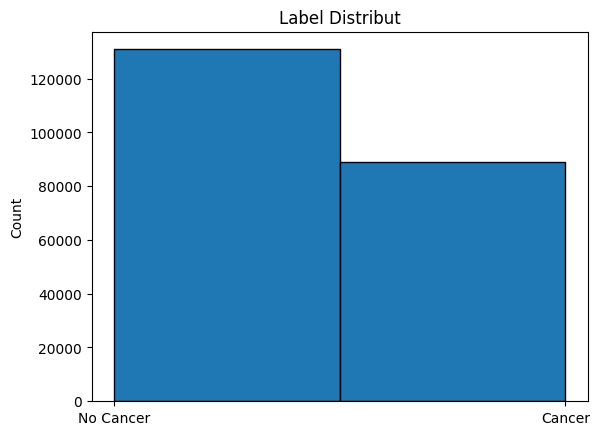

In [5]:
plt.hist(labels_df['label'], bins=2, edgecolor='black')
plt.xticks([0,1], ['No Cancer', 'Cancer'])
plt.ylabel('Count')
plt.title('Label Distribut')
plt.show()

## Load Data for Training

The dataset is very large so it needs to be loaded in batches. Tensorflow's ImageDataGenerator will be used to normalize and load the data in batches. I will also change the target size to `(224, 224)` so it can be used with a pretrained ResNet trained on ImageNet dataset. 

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
img_size = (224,224)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

In [23]:
test_ids = [filename[:-4] for filename in os.listdir(test_dir)]
test_filenames = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=img_size,
    color_mode="rgb",
    batch_size=64,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


## Train Models

## Pre-trained ResNet base

The first model I will try is the ResNet50 model trained on ImageNet. This model is available in tensorflow and will be used as the base of the model. A ResNet model has skip connections that allow information to flow directly through the network. The weights for the base will be frozen and I will add a dense layer and a classification layer to fit to the data. The optimizer is `Adam` and early stopping and a custom learning rate will also be used. The learning rate will start at `0.01` and decay every 4 epochs. 

In [8]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom head on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 [==============================] - 1s 0us/step


In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def custom_learning_rate(epoch):
    initial_lr = 0.01
    drop = 0.5 
    epochs_drop = 4

    lr = initial_lr * (drop ** (epoch // epochs_drop))
    
    return lr

lr_scheduler = LearningRateScheduler(custom_learning_rate)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


initial_lr = 0.01
optimizer = Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
epochs = 20
with tf.device('/GPU:0'):
    history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
5501/5501 [==============================] - 1927s 350ms/step - loss: 0.2838 - accuracy: 0.8845 - val_loss: 0.4021 - val_accuracy: 0.8729 - lr: 0.0100
Epoch 2/20
5501/5501 [==============================] - 1944s 353ms/step - loss: 0.2320 - accuracy: 0.9094 - val_loss: 0.4286 - val_accuracy: 0.8232 - lr: 0.0100
Epoch 3/20
5501/5501 [==============================] - 1939s 353ms/step - loss: 0.2033 - accuracy: 0.9230 - val_loss: 0.2326 - val_accuracy: 0.9103 - lr: 0.0100
Epoch 4/20
5501/5501 [==============================] - 1898s 345ms/step - loss: 0.2005 - accuracy: 0.9242 - val_loss: 0.6033 - val_accuracy: 0.7457 - lr: 0.0100
Epoch 5/20
5501/5501 [==============================] - 1927s 350ms/step - loss: 0.1625 - accuracy: 0.9399 - val_loss: 0.2406 - val_accuracy: 0.9082 - lr: 0.0050
Epoch 6/20
5501/5501 [==============================] - 1931s 351ms/step - loss: 0.1490 - accuracy: 0.9453 - val_loss: 0.2911 - val_accuracy: 0.8958 - lr: 0.0050


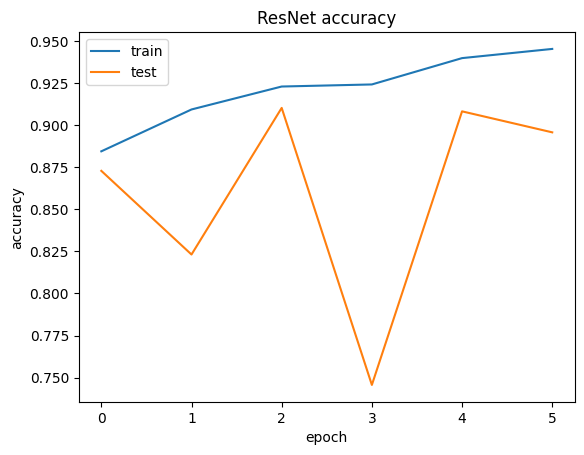

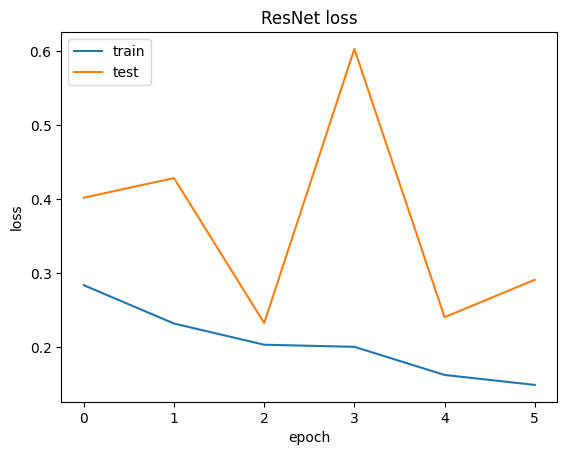

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the training above, early stopping came into play very early on. Training was terminated at epoch=5 because the validation loss was not improving. When I ran the notebook a different time, the training continued further and achieved a better validation and training accuracy. The learning rate schedule could be adjusted further perhaps to achieve better results.  

In [12]:
preds = model.predict(test_generator)


898/898 [==============================] - 605s 670ms/step


In [13]:
results_df = pd.DataFrame({'id':test_ids, 'label':preds.flatten().round().astype('int')})
results_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [14]:
results_df.to_csv('resnet_submission.csv', index=False)

In [15]:
model.save('resnet_model.h5')

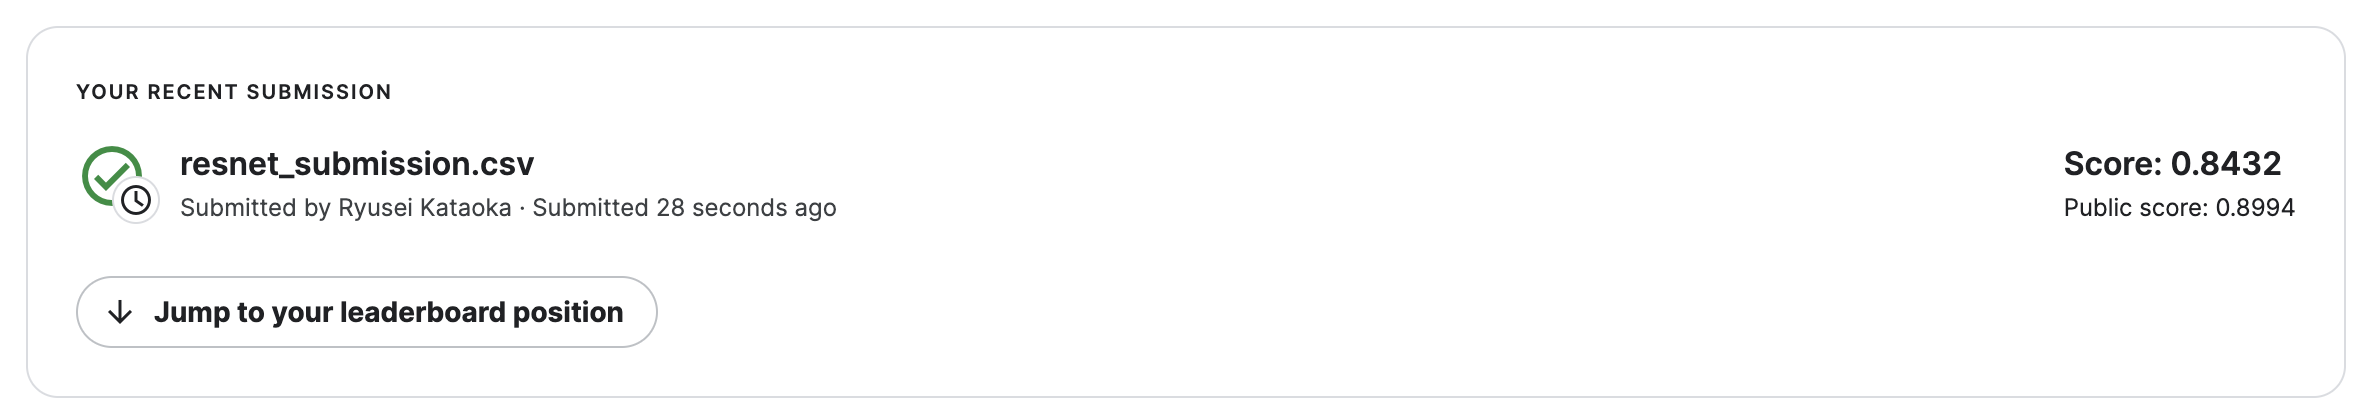


The best accuracy for the resnet model is shown above. The model has a test accuracy of 84%. 

## CNN Model from scratch

I will load the data again with the original image size of `(96, 96)` and build a VGGNet architecture CNN. VGGNet model architecture is very simple and easy to implement in tensorflow. The model has a series of convolution blocks followed by dense layers. This model will be trained from scratch and the model architecture is inspired by [this notebook](https://www.kaggle.com/code/conradkleykamp/histopathologic-cancer-detection-cnn-keras). I will include early stopping to prevent overfitting but keep the learning rate constant at 0.001.

In [39]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
img_size = (96, 96)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    batch_size=50,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    batch_size=50,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=img_size,
    color_mode="rgb",
    batch_size=64,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.
Found 57458 non-validated image filenames.


In [34]:
cnn_model = Sequential()

# Conv1
cnn_model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(Conv2D(32, (3,3), use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPool2D(pool_size = (2,2))) 
cnn_model.add(Dropout(0.3))

# Conv2
cnn_model.add(Conv2D(64, (3,3), use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(Conv2D(64, (3,3), use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPool2D(pool_size = (2,2))) 
cnn_model.add(Dropout(0.3))

# Conv3
cnn_model.add(Conv2D(128, (3,3), use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(Conv2D(128, (3,3), use_bias=False))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPool2D(pool_size = (2,2))) 
cnn_model.add(Dropout(0.3))

# Dense
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation = 'sigmoid'))


In [36]:
optimizer = Adam(0.001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20 
with tf.device('/GPU:0'):
    history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

Epoch 1/20


2023-09-20 16:57:18.557951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3521/3521 [==============================] - 950s 269ms/step - loss: 0.4546 - accuracy: 0.7962 - val_loss: 0.7460 - val_accuracy: 0.7446
Epoch 2/20
3521/3521 [==============================] - 595s 169ms/step - loss: 0.3853 - accuracy: 0.8448 - val_loss: 1.0834 - val_accuracy: 0.7492
Epoch 3/20
3521/3521 [==============================] - 496s 141ms/step - loss: 0.3350 - accuracy: 0.8685 - val_loss: 0.6199 - val_accuracy: 0.7426
Epoch 4/20
3521/3521 [==============================] - 572s 163ms/step - loss: 0.3054 - accuracy: 0.8827 - val_loss: 0.3268 - val_accuracy: 0.8546
Epoch 5/20
3521/3521 [==============================] - 557s 158ms/step - loss: 0.2858 - accuracy: 0.8910 - val_loss: 0.2868 - val_accuracy: 0.8898
Epoch 6/20
3521/3521 [==============================] - 496s 141ms/step - loss: 0.2696 - accuracy: 0.8978 - val_loss: 0.2375 - val_accuracy: 0.9117
Epoch 7/20
3521/3521 [==============================] - 488s 139ms/step - loss: 0.2554 - accuracy: 0.9053 - val_loss: 0.413

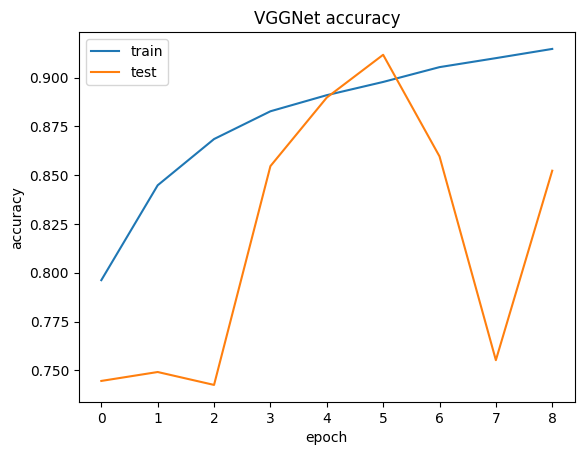

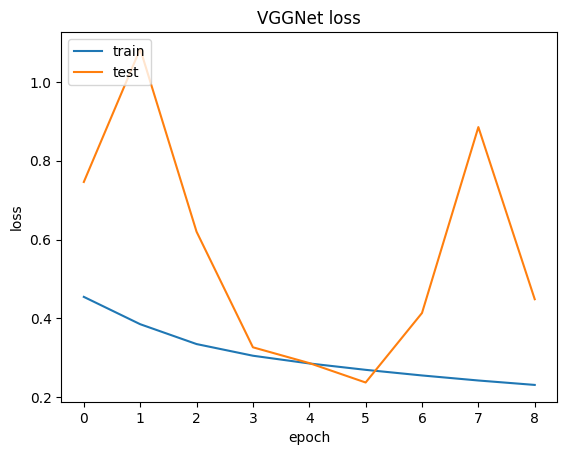

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGGNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGGNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plots above show that the model overfit to the training data after epoch 5. Since we had early stopping with weight restoration on, the model saved the best model. Learning rate scheduling could be explored as well if this project is revisited in the future. 

In [40]:
preds = cnn_model.predict(test_generator)

898/898 [==============================] - 526s 586ms/step


In [46]:
results_df = pd.DataFrame({'id':test_ids, 'label':preds.flatten().round().astype('int')})
results_df.to_csv('cnn_submission.csv', index=False)

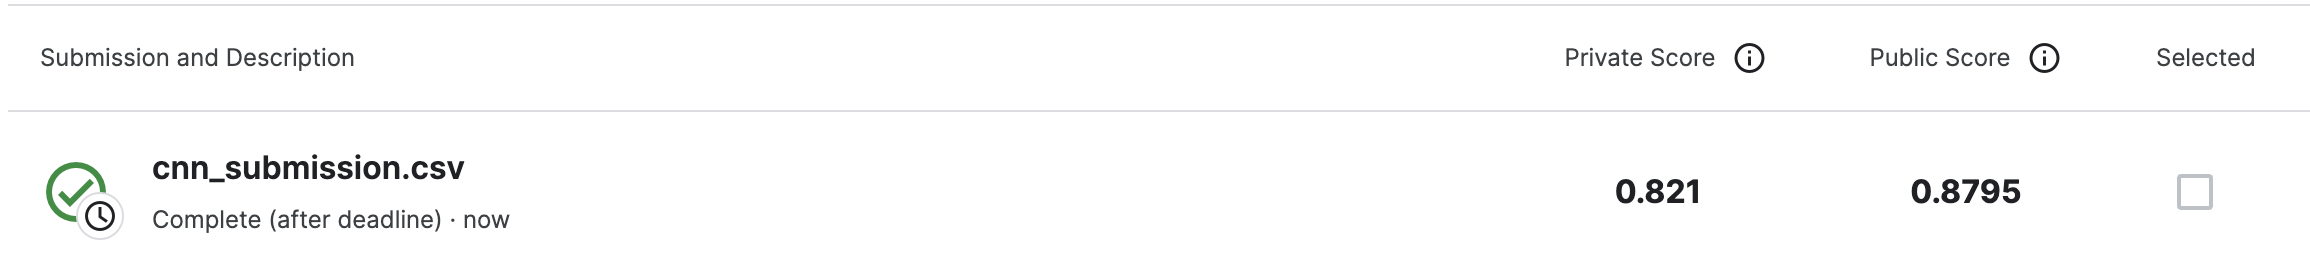


In [45]:
VGG_model.save('cnn_model.h5')

The results are shown in the image above. The results are slightly worse than the resnet model but are pretty comparable. The results could probably improved with further hyperparameter tuning.

## Conclusion

In conclusion, I was able to achieve a public score of 0.89 and 0.87 for the pre-trained Resnet model and the VGGNet model respectively. Both results are decent accuracy but there is still much room for improvement. Further hyperparameter tuning, balancing the dataset, data-preprocessing such as image augmentation could be experimented with if this project is revisited.

It should be noted that the time it takes to train these deep learning models is a large factor to consider for these types of problems and was a limiting factor for this project. 